In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime

import math
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm
plt.style.use("fivethirtyeight")
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
org_col_names=["No", "year","month", "day", "hour", "pm2.5", "DEWP","TEMP", "PRES", "cbwd", "Iws", "Is", "Ir"]
col_names = ['Year','Month', 'Day', 'Hour','PM2.5', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain','Timestamp']   
                        
data = pd.read_csv('../input/data-airpollution/AirPollution.csv')  
data.head()
df=data.copy()
df['Timestamp'] = pd.to_datetime(df[['year','month','day']].astype(str).apply(' '.join, 1), format='%Y %m %d')



In [3]:
# Data cleaning
df.drop('No', axis=1, inplace=True)
df.columns = col_names
df['PM2.5'].fillna(0, inplace=True)
df = df.reindex(['Timestamp','Year','Month', 'Day', 'Hour','PM2.5', 'dew', 'temp', 'pressure', 'w_dir', 'w_speed', 'snow', 'rain'], axis=1)
#df = df[24:] # drop the first day
df.head()


,Timestamp,Year,Month,Day,Hour,PM2.5,dew,temp,pressure,w_dir,w_speed,snow,rain
0,2010-01-01,2010,1,1,0,0.0,-21,-11.0,1021.0,NW,1.79,0,0
1,2010-01-01,2010,1,1,1,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2,2010-01-01,2010,1,1,2,0.0,-21,-11.0,1019.0,NW,6.71,0,0
3,2010-01-01,2010,1,1,3,0.0,-21,-14.0,1019.0,NW,9.84,0,0
4,2010-01-01,2010,1,1,4,0.0,-20,-12.0,1018.0,NW,12.97,0,0


In [4]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [5]:
df.head()

,Timestamp,Year,Month,Day,Hour,PM2.5,dew,temp,pressure,w_dir,w_speed,snow,rain
0,2010-01-01,2010,1,1,0,0.0,-21,-11.0,1021.0,NW,1.79,0,0
1,2010-01-01,2010,1,1,1,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2,2010-01-01,2010,1,1,2,0.0,-21,-11.0,1019.0,NW,6.71,0,0
3,2010-01-01,2010,1,1,3,0.0,-21,-14.0,1019.0,NW,9.84,0,0
4,2010-01-01,2010,1,1,4,0.0,-20,-12.0,1018.0,NW,12.97,0,0


In [6]:
df['Date']=df["Timestamp"].dt.date

# Visualization

* Time series by days

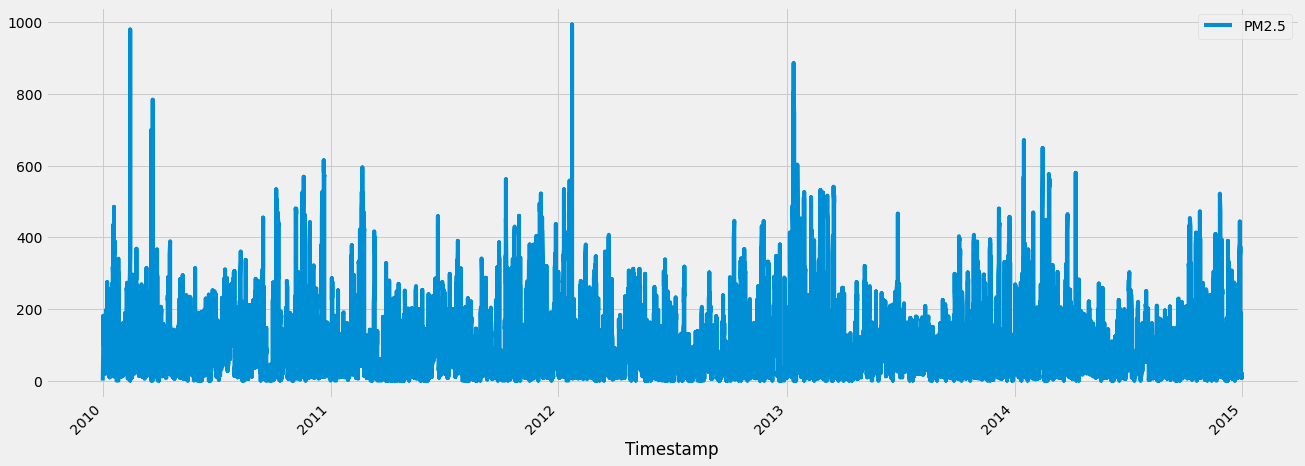

In [7]:
df.plot(x='Timestamp',y='PM2.5',figsize=(20,8))
plt.xticks(rotation=45)

plt.show()

* Time series by year average

<AxesSubplot:xlabel='Year'>

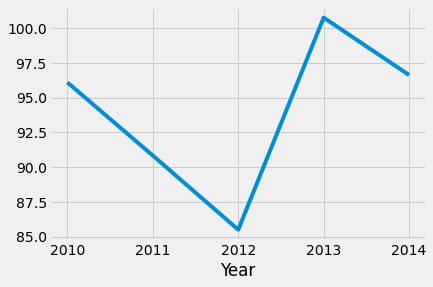

In [8]:
df.groupby('Year')['PM2.5'].mean().plot()

* Boxplot by year

<AxesSubplot:xlabel='Year', ylabel='PM2.5'>

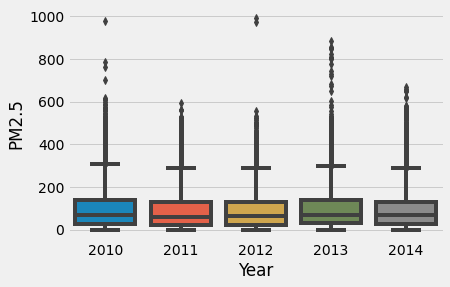

In [9]:
df_year=df.loc[:,['Year','PM2.5']]
sns.boxplot(x='Year', y='PM2.5',data=df_year)

* Time series by month average

<AxesSubplot:xlabel='Month'>

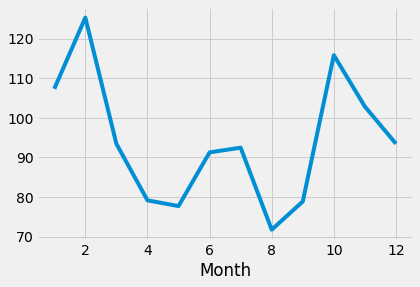

In [10]:
df.groupby('Month')['PM2.5'].mean().plot()

* Boxplot by month

<AxesSubplot:xlabel='Month', ylabel='PM2.5'>

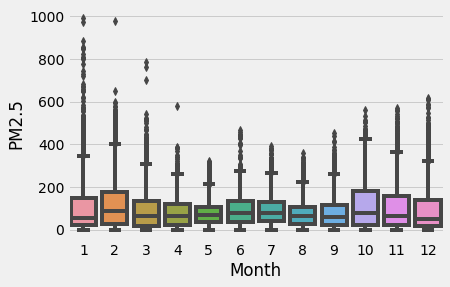

In [11]:
df_month=df.loc[:,['Month','PM2.5']]
sns.boxplot(x='Month', y='PM2.5',data=df_month)

* Time series by day average

<AxesSubplot:xlabel='Date'>

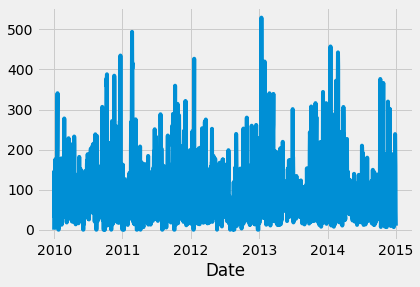

In [12]:
df.groupby('Date')['PM2.5'].mean().plot()

* Boxplot by day

<AxesSubplot:xlabel='Day', ylabel='PM2.5'>

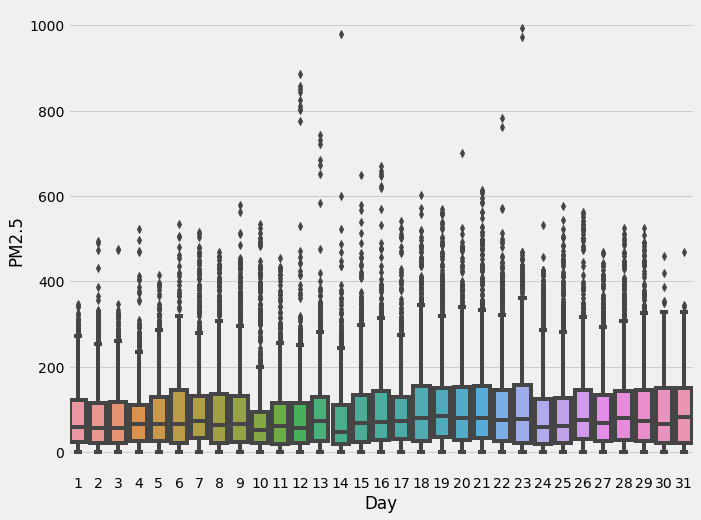

In [13]:
df_day=df.loc[:,['Day','PM2.5']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Day', y='PM2.5',data=df_day)

* Time series by hour average

<AxesSubplot:xlabel='Hour'>

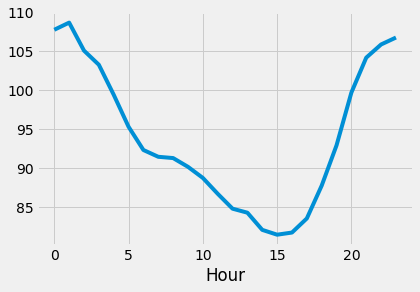

In [14]:
df.groupby('Hour')['PM2.5'].mean().plot()

* Boxplot by hour

<AxesSubplot:xlabel='Hour', ylabel='PM2.5'>

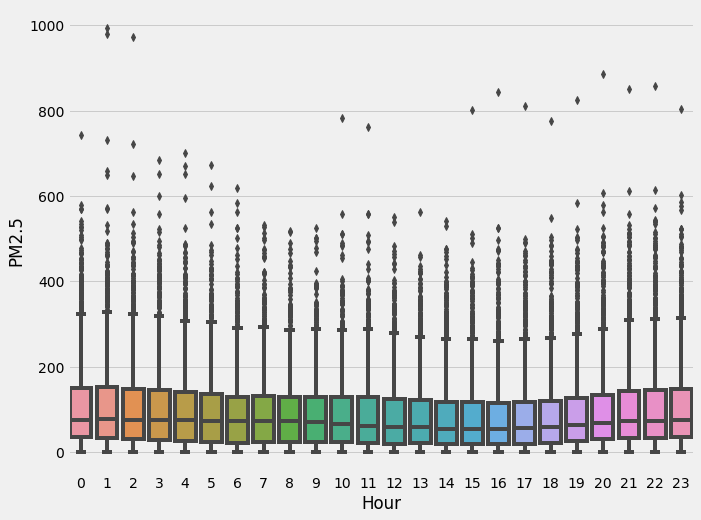

In [15]:
df_hour=df.loc[:,['Hour','PM2.5']]
plt.figure(figsize=(10,8))
sns.boxplot(x='Hour', y='PM2.5',data=df_hour)

# Prediction Model

* I tried to find the prediction model by each days average. So first, I made each days average data set.

In [16]:
df_date=pd.DataFrame(df.groupby('Date')['PM2.5'].mean())
df_date

,PM2.5
Date,
2010-01-01,0.000000
2010-01-02,145.958333
2010-01-03,78.833333
2010-01-04,31.333333
2010-01-05,42.458333
...,...
2014-12-27,238.666667
2014-12-28,197.375000
2014-12-29,159.000000


* Time series by each days average

<AxesSubplot:xlabel='Date'>

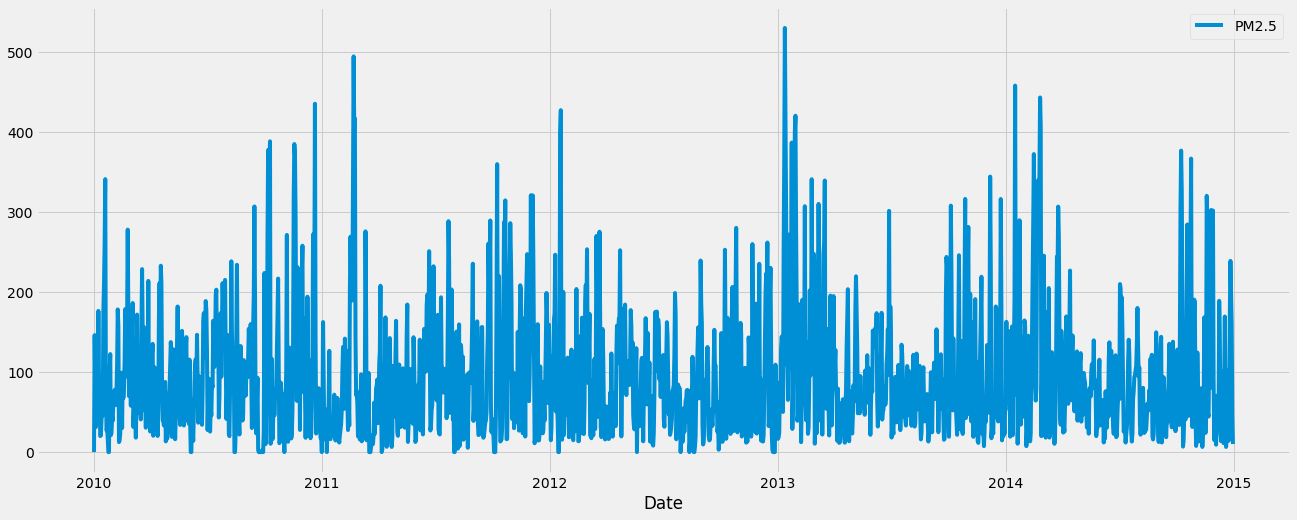

In [17]:
df_date.plot(figsize=(20,8))

* Split data into train 80% and test 20%

In [18]:
dataset  = df_date.values
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1461

* Standardization by MinMaxScaler

In [19]:
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.        ],
       [0.27567482],
       [0.14889431],
       ...,
       [0.30030692],
       [0.08703864],
       [0.01896592]])

In [20]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
len(train_data)
num = 60
for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])    

In [21]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1401, 60, 1)

* Model kết hợp CNN LSTM

In [22]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))
#model.add(Flatten())

#model.add(LSTM(60, return_sequences=True))
model.add(LSTM(64))
#model.add(Dense(units=x_train.shape[1], activation='linear'))

model.add(Dense(50, activation='linear'))
model.add(Dense(1))

2022-11-01 15:26:57.056186: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [23]:
'''
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
model = Sequential()
epochs = 40
batch = 256
lr = 0.0003
adam = Adam(lr)

#model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train.shape[1],1))))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

'''

"\nfrom keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten\nmodel = Sequential()\nepochs = 40\nbatch = 256\nlr = 0.0003\nadam = Adam(lr)\n\n#model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))\nmodel.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train.shape[1],1))))\nmodel.add(TimeDistributed(MaxPooling1D(pool_size=2)))\nmodel.add(TimeDistributed(Flatten()))\nmodel.add(LSTM(50, activation='relu'))\nmodel.add(Dense(1))\n\n"

In [24]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [25]:
model.fit(x_train,y_train, batch_size=100, epochs=1)

2022-11-01 15:26:57.673867: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


15/15 [==============================] - 3s 37ms/step - loss: 0.0253


* Prediction

In [26]:
test_data = scaled_data[training_data_len-60: , :]
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

In [27]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [28]:
predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

In [29]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

21.885230352671723

In [30]:
train = df_date[:training_data_len]
valid = df_date[training_data_len:]
valid["Predictions"] = predictions
valid

,PM2.5,Predictions
Date,,
2014-01-01,53.416667,72.802887
2014-01-02,162.625000,67.998299
2014-01-03,61.916667,68.157700
2014-01-04,150.416667,69.183823
2014-01-05,104.083333,70.459023
...,...,...
2014-12-27,238.666667,62.946190
2014-12-28,197.375000,68.869461
2014-12-29,159.000000,72.941154


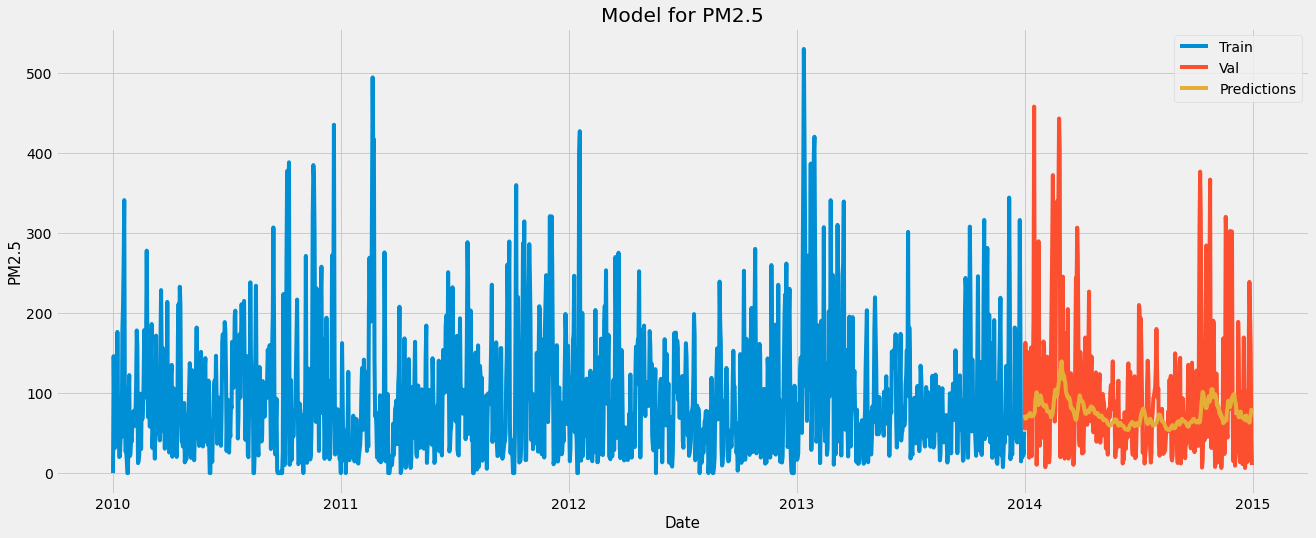

In [31]:
plt.figure(figsize=(20,8))
plt.title("Model for PM2.5")
plt.xlabel("Date", fontsize = 15)
plt.ylabel("PM2.5",fontsize=15)
plt.plot(train[df_date.columns])
plt.plot(valid['PM2.5'])
plt.plot(valid["Predictions"])
plt.legend(["Train","Val","Predictions"])

Thank you !